## Import Libraries

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

## Load Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

## EDA

### 기본 데이터 확인

In [3]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [4]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [5]:
pd.value_counts(train['letter'])

Z    91
O    90
K    90
H    89
L    89
G    87
M    86
Y    86
U    85
Q    82
T    82
R    81
F    80
X    79
N    77
S    76
D    76
C    74
V    73
A    72
B    71
W    69
J    67
E    66
P    66
I    64
Name: letter, dtype: int64

## 데이터 시각화

In [6]:
train.shape

(2048, 787)

In [7]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [8]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

### 원본 데이터 시각화

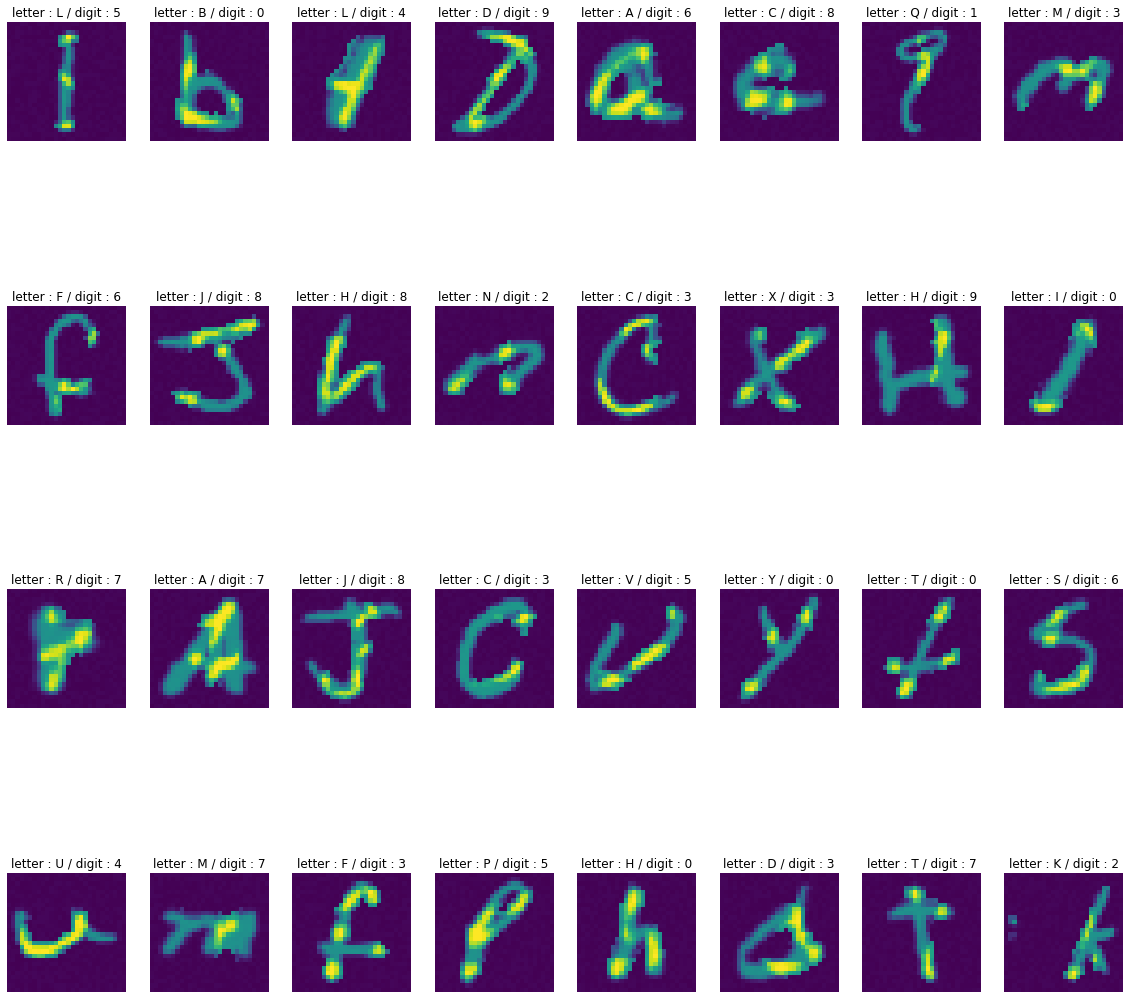

In [9]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

우리 눈에는 알파벳 모양만 보이고 숫자는 가려져서 잘 보이지 않습니다.  
원본 데이터는 숫자 위에 알파벳 마스크가 덮여져 있는 상태입니다. 

## utility function

뒤에서 사용할 함수를 미리 만들어 줍니다.

### 모델 학습 graph 

In [10]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [11]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

### alphabet one-hot encoding (사용 안함)

In [12]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

## Feature Engineering

In [13]:
X_train = train.drop(['letter','id', 'digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)
X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)
print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [14]:
X_train = train.drop(['letter','id','digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)

X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)

print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [15]:
y_trains = train['digit']
y_trains = utils.to_categorical(y_trains, 10)
y_trains.shape

(2048, 10)

원본 데이터는 채널이 1개만 있습니다.  
우리는 이걸 3채널로 바꿀 것 입니다. 

### 숫자만 따로 분리하기

In [16]:
X_train_digit = digit_image(X_trains)
TEST_digit = digit_image(TEST)
X_train_digit.shape

(2048, 28, 28, 1)

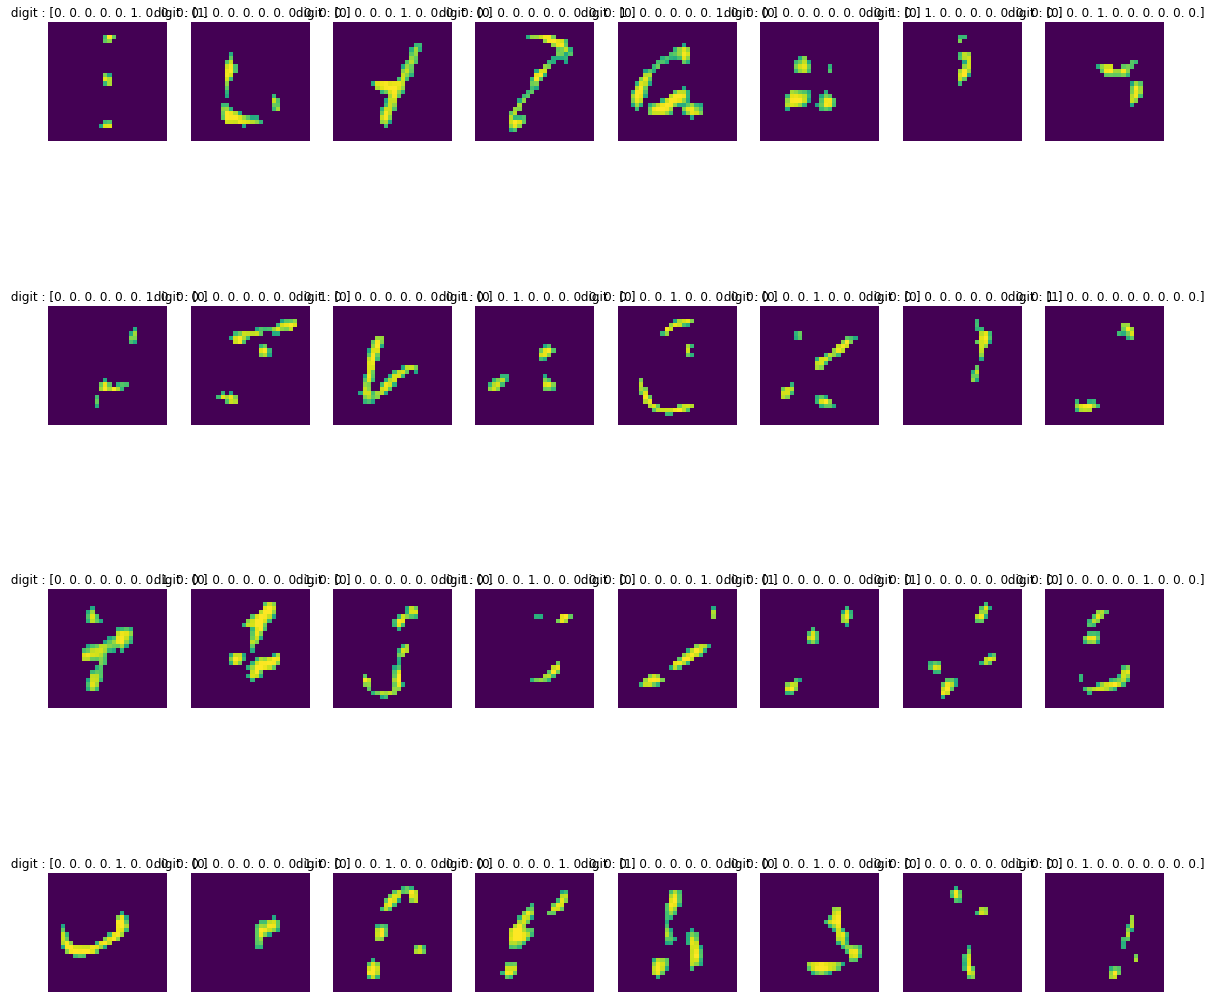

In [17]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(y_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_digit[idx]))
    title = ' digit : {}'.format(digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 알파벳만 따로 분리하기

In [18]:
X_train_alpha = X_trains - X_train_digit/2
TEST_alpha = TEST - TEST_digit/2

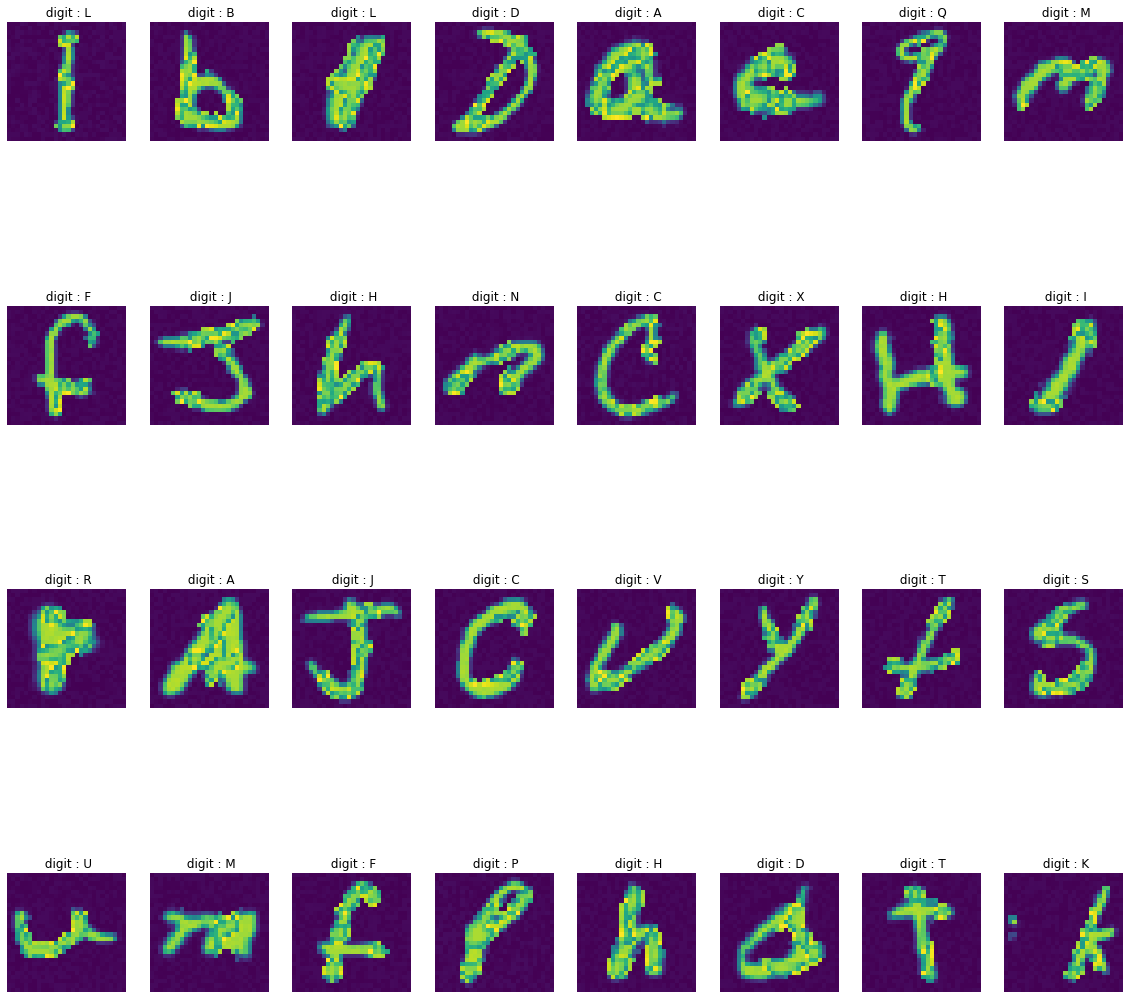

In [19]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_train_letter[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_alpha[idx]))
    title = ' digit : {}'.format(letter)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 3채널 만들기 (원본, 숫자, 글자)

In [20]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
TEST = np.concatenate((TEST, TEST_digit, TEST_alpha),axis=-1)
print(X_trains.shape)
print(TEST.shape)
print(y_trains.shape)

(2048, 28, 28, 3)
(20480, 28, 28, 3)
(2048, 10)


## Augmentation

In [21]:
# train1 = np.rot90(X_trains, 1, (1,2))
# train2 = np.rot90(X_trains, 2, (1,2))
# train3 = np.rot90(X_trains, 3, (1,2))
# train_lr = np.fliplr(X_trains)
# train_ud = np.flipud(X_trains)

# X_trains = np.vstack([X_trains, train1])
# del train1

# X_trains = np.vstack([X_trains, train2])
# del train2

# X_trains = np.vstack([X_trains, train3])
# del train3

# X_trains = np.vstack([X_trains, train_lr])
# del train_lr

# X_trains = np.vstack([X_trains, train_ud])
# del train_ud

# print(X_trains.shape)

In [22]:
# y = y_trains
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# y_trains = np.vstack([y_trains, y])
# print(y_trains.shape)

## Train

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [24]:
reduction_ratio=8
axis = 3
groups_size = 8

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D, Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


### RexNet

In [26]:
def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

### Unet

In [27]:
# Generate model
def unet_classification(shape, activation='elu', weight=False):
    '''
    activation : relu or elu
    weight : 로드할 모델의 가중치의 여부
    '''
    drop = 0.5
    
    unit1 = 64
    unit2 = 128
    unit3 = 256
    unit4 = 512
    unit5 = 1024
    # 28 x 28 x 3
    inputs = Input(shape)
    # 28 x 28 x 64
    conv0 = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) 
    # 56 x 56 x 64
    conv0 = UpSampling2D(size=(2,2))(conv0)
    # 56 x 56 x 64
    conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    # 28 x 28 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop)(pool1)
    # 28 x 28 x 128
    conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation)(conv2)
    conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation)(conv2)
    # 14 x 14 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(drop)(pool2)
    # 14 x 14 x 256
    conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation)(conv3)
    conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation)(conv3)
    # 7 x 7 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop)(pool3)
    # 7 x 7 x 512
    conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation)(conv4)
    conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation)(conv4)
    # 2 x 2 x 512
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    pool4 = Dropout(drop)(pool4)
    # 2 x 2 x 1024
    conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation)(conv5)
    conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation)(conv5)

    flatten1 = tf.keras.layers.Flatten()(conv5)

    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)
    return model


### Inception

In [28]:
def inception(shape, LOOP=7):
    unit1 = 64
    unit2 = 128
    unit3 = 256
    unit4 = 512
    unit5 = 1024
    drop = 0.5
    
    inputs = Input(shape)
    activation_ = 'elu'
    
    conv1 = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) 
    # 56 x 56 x 64
    conv1 = UpSampling2D(size=(2,2))(conv1)
#     inputs = BatchNormalization()(inputs)
    # 56 x 56 x 64
    conv1 = Conv2D(unit1, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation_)(conv1)
    # 28 x 28 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop)(pool1)
    # 28 x 28 x 128
    conv2 = Conv2D(unit2, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation_)(conv2)
    # 14 x 14 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(drop)(pool2)
    # 14 x 14 x 256
    conv3 = Conv2D(unit3, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation_)(conv3)
    # 7 x 7 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop)(pool3)
    
    # 7 x 7 x 512
    for i in range(LOOP):
        incep1 = BatchNormalization()(pool3)
        incep1 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)

        incep3 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)
        incep3 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep3)

        incep5 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep3)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)

        pool1 = AveragePooling2D(
            pool_size=(3, 3), strides=1, padding='same')(incep5)
        pool1 = Conv2D(32, 1, padding='same', activation=activation_)(pool1)

        concat = concatenate([incep1, incep3, incep5, pool1])
        
    # 7 x 7 x 1024
    conv4 = BatchNormalization()(concat)
    conv4 = Conv2D(unit5, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation_)(conv4)
    
    # 2 x 2 x 1024
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    pool4 = Dropout(drop)(pool4)
    
    flatten1 = tf.keras.layers.Flatten()(pool4)
        
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [29]:
X_trains.shape

(2048, 28, 28, 3)

In [30]:
y_trains.shape

(2048, 10)

In [31]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [32]:
SEED = 2020
X_trains = X_trains/255.0

In [33]:
X_trains.shape

(2048, 28, 28, 3)

In [82]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=3, shuffle=True, random_state=SEED)
    
    epochs = 1
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 5.0220 - accuracy: 0.1021
Epoch 00001: val_loss improved from inf to 3.21700, saving model to model1_best_0.h5
42/42 [==============================] - 2s 57ms/step - loss: 4.9742 - accuracy: 0.1012 - val_loss: 3.2170 - val_accuracy: 0.0864 - lr: 0.0010


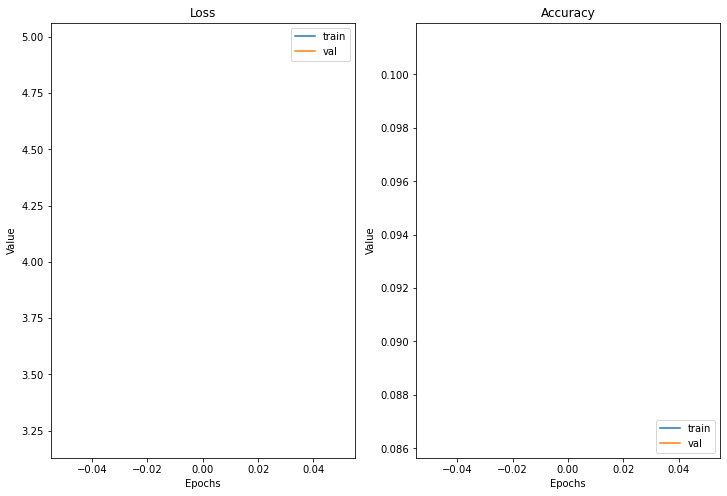

*******************number_2_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 5.5117 - accuracy: 0.1159
Epoch 00001: val_loss improved from inf to 2.34171, saving model to model1_best_0.h5
42/42 [==============================] - 2s 59ms/step - loss: 5.4518 - accuracy: 0.1146 - val_loss: 2.3417 - val_accuracy: 0.1025 - lr: 0.0010


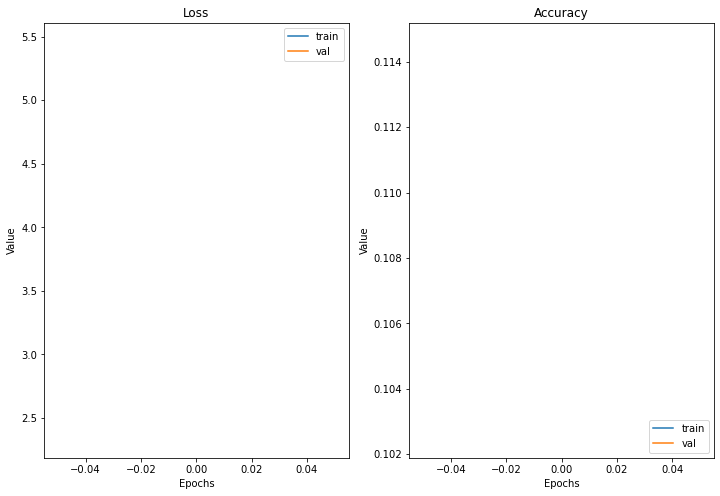

*******************number_3_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 5.3991 - accuracy: 0.1021
Epoch 00001: val_loss improved from inf to 2.35422, saving model to model1_best_0.h5
42/42 [==============================] - 2s 57ms/step - loss: 5.3517 - accuracy: 0.1019 - val_loss: 2.3542 - val_accuracy: 0.1877 - lr: 0.0010


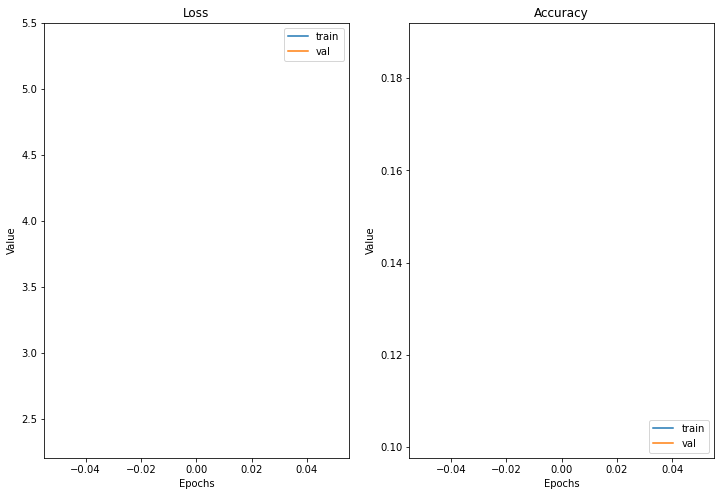

In [83]:
RX_train, RX_test = get_stacking(rexnet_model, X_trains, y_trains)

In [86]:
RX_train

array([[7],
       [7],
       [1],
       ...,
       [4],
       [1],
       [1]])

In [87]:
RX_train.shape

(2048, 1)

In [90]:
RX_test

array([[6],
       [0],
       [0],
       ...,
       [4],
       [0],
       [0]])

In [91]:
RX_test.shape

(20480, 1)

In [186]:
IN_train, IN_test = get_stacking(inception, X_trains, y_trains)

*******************number_1_kfold_model*******************


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

*******************number_1_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 5.6204 - accuracy: 0.0915
Epoch 00001: val_loss improved from inf to 3.00507, saving model to model1_best_0.h5
56/56 [==============================] - 3s 61ms/step - loss: 5.6204 - accuracy: 0.0915 - val_loss: 3.0051 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.0184 - accuracy: 0.1016
Epoch 00002: val_loss improved from 3.00507 to 2.52681, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 3.0184 - accuracy: 0.1016 - val_loss: 2.5268 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.7900 - accuracy: 0.1077
Epoch 00003: val_loss improved from 2.52681 to 2.44262, saving model to model1_best_0.h5
56/56 [==============================] - 3s 55ms/step - loss: 2.7900 - accuracy: 0.1077 - val_loss: 2.4426 

Epoch 54/500
56/56 [==============================] - ETA: 0s - loss: 1.6735 - accuracy: 0.4023
Epoch 00054: val_loss improved from 1.39859 to 1.39259, saving model to model1_best_0.h5
56/56 [==============================] - 3s 60ms/step - loss: 1.6735 - accuracy: 0.4023 - val_loss: 1.3926 - val_accuracy: 0.4883 - lr: 5.1200e-04
Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.6590 - accuracy: 0.4062
Epoch 00055: val_loss did not improve from 1.39259
56/56 [==============================] - 3s 50ms/step - loss: 1.6590 - accuracy: 0.4062 - val_loss: 1.4768 - val_accuracy: 0.4648 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.4118
Epoch 00056: val_loss did not improve from 1.39259
56/56 [==============================] - 3s 51ms/step - loss: 1.6948 - accuracy: 0.4118 - val_loss: 1.4293 - val_accuracy: 0.5078 - lr: 5.1200e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.6915 - a

Epoch 81/500
55/56 [============================>.] - ETA: 0s - loss: 1.3805 - accuracy: 0.5182
Epoch 00081: val_loss improved from 1.03320 to 0.98120, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 1.3831 - accuracy: 0.5179 - val_loss: 0.9812 - val_accuracy: 0.6328 - lr: 2.6214e-04
Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.5045
Epoch 00082: val_loss did not improve from 0.98120
56/56 [==============================] - 3s 49ms/step - loss: 1.3898 - accuracy: 0.5045 - val_loss: 1.0976 - val_accuracy: 0.6328 - lr: 2.6214e-04
Epoch 83/500
55/56 [============================>.] - ETA: 0s - loss: 1.4011 - accuracy: 0.5176
Epoch 00083: val_loss did not improve from 0.98120
56/56 [==============================] - 3s 50ms/step - loss: 1.3923 - accuracy: 0.5212 - val_loss: 1.0265 - val_accuracy: 0.6016 - lr: 2.6214e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 1.3756 - a

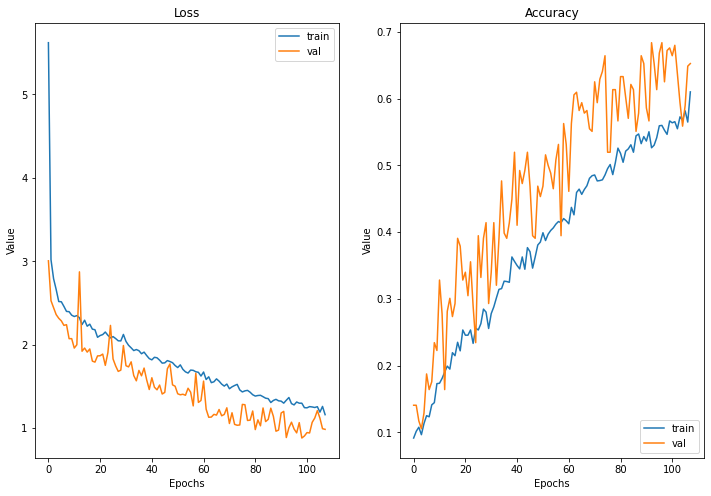

*******************number_2_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 5.0505 - accuracy: 0.1099
Epoch 00001: val_loss improved from inf to 4.98870, saving model to model1_best_0.h5
56/56 [==============================] - 3s 61ms/step - loss: 5.0505 - accuracy: 0.1099 - val_loss: 4.9887 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 2.9807 - accuracy: 0.1155
Epoch 00002: val_loss did not improve from 4.98870
56/56 [==============================] - 3s 51ms/step - loss: 2.9807 - accuracy: 0.1155 - val_loss: 5.3147 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.9249 - accuracy: 0.1049
Epoch 00003: val_loss improved from 4.98870 to 2.35776, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 2.9249 - accuracy: 0.1049 - val_loss: 2.3578 - val_accuracy: 0.1133 - lr: 0.0010
Ep

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.0329 - accuracy: 0.2824
Epoch 00028: val_loss improved from 1.69996 to 1.58189, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 2.0329 - accuracy: 0.2824 - val_loss: 1.5819 - val_accuracy: 0.4336 - lr: 6.4000e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 2.0527 - accuracy: 0.2545
Epoch 00029: val_loss did not improve from 1.58189
56/56 [==============================] - 3s 50ms/step - loss: 2.0527 - accuracy: 0.2545 - val_loss: 1.7048 - val_accuracy: 0.3945 - lr: 6.4000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0490 - accuracy: 0.2679
Epoch 00030: val_loss did not improve from 1.58189
56/56 [==============================] - 3s 50ms/step - loss: 2.0490 - accuracy: 0.2679 - val_loss: 1.9411 - val_accuracy: 0.3281 - lr: 6.4000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.9940 - a

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.7471 - accuracy: 0.3800
Epoch 00055: val_loss did not improve from 1.29166
56/56 [==============================] - 3s 50ms/step - loss: 1.7471 - accuracy: 0.3800 - val_loss: 1.3894 - val_accuracy: 0.5312 - lr: 5.1200e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.7600 - accuracy: 0.3795
Epoch 00056: val_loss improved from 1.29166 to 1.28304, saving model to model1_best_0.h5
56/56 [==============================] - 3s 54ms/step - loss: 1.7600 - accuracy: 0.3795 - val_loss: 1.2830 - val_accuracy: 0.5664 - lr: 5.1200e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.7120 - accuracy: 0.4091
Epoch 00057: val_loss did not improve from 1.28304
56/56 [==============================] - 3s 50ms/step - loss: 1.7079 - accuracy: 0.4090 - val_loss: 1.3032 - val_accuracy: 0.5508 - lr: 5.1200e-04
Epoch 58/500
56/56 [==============================] - ETA: 0s - loss: 1.7091 - a

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.4644 - accuracy: 0.4989
Epoch 00082: val_loss did not improve from 0.84777
56/56 [==============================] - 3s 49ms/step - loss: 1.4644 - accuracy: 0.4989 - val_loss: 0.9130 - val_accuracy: 0.7148 - lr: 4.0960e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.4683 - accuracy: 0.4955
Epoch 00083: val_loss did not improve from 0.84777
56/56 [==============================] - 3s 50ms/step - loss: 1.4683 - accuracy: 0.4955 - val_loss: 0.9907 - val_accuracy: 0.6406 - lr: 4.0960e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 1.3936 - accuracy: 0.5123
Epoch 00084: val_loss did not improve from 0.84777
56/56 [==============================] - 3s 49ms/step - loss: 1.3936 - accuracy: 0.5123 - val_loss: 0.9462 - val_accuracy: 0.6562 - lr: 3.2768e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 1.4296 - accuracy: 0.5039
Epoch 00085: val_loss 

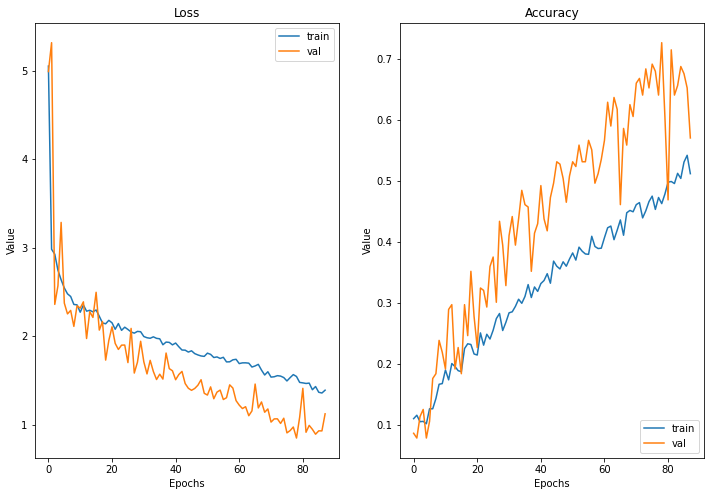

*******************number_3_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.3717 - accuracy: 0.1159
Epoch 00001: val_loss improved from inf to 10.27619, saving model to model1_best_0.h5
56/56 [==============================] - 3s 59ms/step - loss: 5.3299 - accuracy: 0.1172 - val_loss: 10.2762 - val_accuracy: 0.1211 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 2.9955 - accuracy: 0.1066
Epoch 00002: val_loss improved from 10.27619 to 2.97182, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 2.9955 - accuracy: 0.1066 - val_loss: 2.9718 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8583 - accuracy: 0.1114
Epoch 00003: val_loss improved from 2.97182 to 2.40362, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 2.8537 - accuracy: 0.1105 - val_loss: 2.40

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 2.0117 - accuracy: 0.2974
Epoch 00028: val_loss improved from 1.71097 to 1.58668, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 2.0117 - accuracy: 0.2974 - val_loss: 1.5867 - val_accuracy: 0.4492 - lr: 5.1200e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.9470 - accuracy: 0.3006
Epoch 00029: val_loss did not improve from 1.58668
56/56 [==============================] - 3s 50ms/step - loss: 1.9460 - accuracy: 0.3008 - val_loss: 1.7132 - val_accuracy: 0.3555 - lr: 5.1200e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.9578 - accuracy: 0.3158
Epoch 00030: val_loss did not improve from 1.58668
56/56 [==============================] - 3s 50ms/step - loss: 1.9578 - accuracy: 0.3158 - val_loss: 1.6172 - val_accuracy: 0.4258 - lr: 5.1200e-04
Epoch 31/500
56/56 [==============================] - ETA: 0s - loss: 1.9588 - a

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.6798 - accuracy: 0.4152
Epoch 00055: val_loss improved from 1.27433 to 1.23184, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 1.6798 - accuracy: 0.4152 - val_loss: 1.2318 - val_accuracy: 0.5625 - lr: 2.0972e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.6021 - accuracy: 0.4481
Epoch 00056: val_loss did not improve from 1.23184
56/56 [==============================] - 3s 49ms/step - loss: 1.6021 - accuracy: 0.4481 - val_loss: 1.3001 - val_accuracy: 0.5586 - lr: 2.0972e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.6575 - accuracy: 0.4170
Epoch 00057: val_loss improved from 1.23184 to 1.21875, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 1.6580 - accuracy: 0.4163 - val_loss: 1.2187 - val_accuracy: 0.5898 - lr: 2.0972e-04
Epoch 58/500
56/56 [======================

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.4950
Epoch 00082: val_loss improved from 1.00705 to 0.99839, saving model to model1_best_0.h5
56/56 [==============================] - 3s 55ms/step - loss: 1.4510 - accuracy: 0.4950 - val_loss: 0.9984 - val_accuracy: 0.6602 - lr: 1.0737e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.4480 - accuracy: 0.5112
Epoch 00083: val_loss did not improve from 0.99839
56/56 [==============================] - 3s 50ms/step - loss: 1.4480 - accuracy: 0.5112 - val_loss: 1.0401 - val_accuracy: 0.6328 - lr: 1.0737e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5156
Epoch 00084: val_loss did not improve from 0.99839
56/56 [==============================] - 3s 49ms/step - loss: 1.3794 - accuracy: 0.5156 - val_loss: 1.1252 - val_accuracy: 0.5977 - lr: 1.0737e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 1.4161 - a

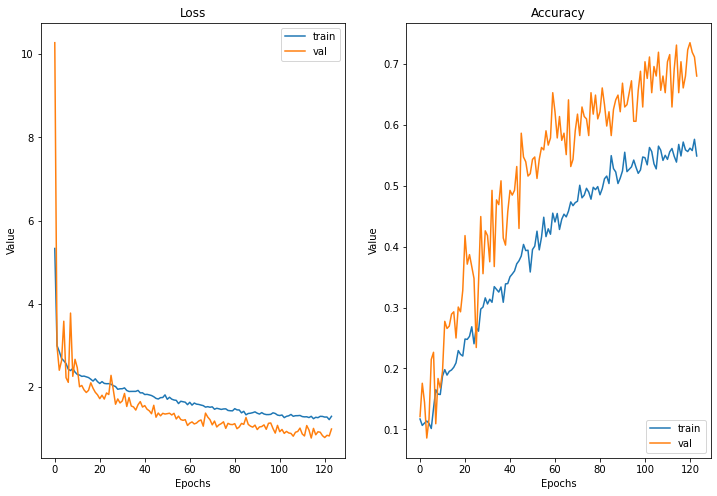

*******************number_4_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 4.8917 - accuracy: 0.1183
Epoch 00001: val_loss improved from inf to 2.49527, saving model to model1_best_0.h5
56/56 [==============================] - 3s 60ms/step - loss: 4.8917 - accuracy: 0.1183 - val_loss: 2.4953 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 3.0778 - accuracy: 0.1110
Epoch 00002: val_loss improved from 2.49527 to 2.34012, saving model to model1_best_0.h5
56/56 [==============================] - 3s 55ms/step - loss: 3.0778 - accuracy: 0.1110 - val_loss: 2.3401 - val_accuracy: 0.1602 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.9421 - accuracy: 0.1211
Epoch 00003: val_loss did not improve from 2.34012
56/56 [==============================] - 3s 50ms/step - loss: 2.9421 - accuracy: 0.1211 - val_loss: 2.6022 - val_accuracy: 0.1172 - lr: 0.0010
Ep

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.0492 - accuracy: 0.2739
Epoch 00028: val_loss improved from 1.74418 to 1.64413, saving model to model1_best_0.h5
56/56 [==============================] - 3s 52ms/step - loss: 2.0500 - accuracy: 0.2734 - val_loss: 1.6441 - val_accuracy: 0.4648 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 2.0181 - accuracy: 0.2670
Epoch 00029: val_loss did not improve from 1.64413
56/56 [==============================] - 2s 45ms/step - loss: 2.0196 - accuracy: 0.2656 - val_loss: 1.6925 - val_accuracy: 0.4219 - lr: 8.0000e-04
Epoch 30/500
55/56 [============================>.] - ETA: 0s - loss: 2.0694 - accuracy: 0.2551
Epoch 00030: val_loss did not improve from 1.64413
56/56 [==============================] - 2s 45ms/step - loss: 2.0703 - accuracy: 0.2556 - val_loss: 2.0674 - val_accuracy: 0.1797 - lr: 8.0000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 2.0780 - a

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.7085 - accuracy: 0.3934
Epoch 00055: val_loss did not improve from 1.30215
56/56 [==============================] - 3s 50ms/step - loss: 1.7085 - accuracy: 0.3934 - val_loss: 1.4318 - val_accuracy: 0.4844 - lr: 4.0960e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.6813 - accuracy: 0.4017
Epoch 00056: val_loss improved from 1.30215 to 1.22332, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 1.6826 - accuracy: 0.4023 - val_loss: 1.2233 - val_accuracy: 0.5703 - lr: 4.0960e-04
Epoch 57/500
56/56 [==============================] - ETA: 0s - loss: 1.6757 - accuracy: 0.4163
Epoch 00057: val_loss did not improve from 1.22332
56/56 [==============================] - 3s 52ms/step - loss: 1.6757 - accuracy: 0.4163 - val_loss: 1.2470 - val_accuracy: 0.5547 - lr: 4.0960e-04
Epoch 58/500
55/56 [============================>.] - ETA: 0s - loss: 1.6900 - a

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.3965 - accuracy: 0.5195
Epoch 00082: val_loss did not improve from 0.78977
56/56 [==============================] - 3s 50ms/step - loss: 1.3965 - accuracy: 0.5195 - val_loss: 1.0806 - val_accuracy: 0.6211 - lr: 2.0972e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.5469
Epoch 00083: val_loss did not improve from 0.78977
56/56 [==============================] - 3s 50ms/step - loss: 1.3488 - accuracy: 0.5469 - val_loss: 1.0595 - val_accuracy: 0.6211 - lr: 2.0972e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 1.3512 - accuracy: 0.5415
Epoch 00084: val_loss did not improve from 0.78977
56/56 [==============================] - 3s 50ms/step - loss: 1.3465 - accuracy: 0.5419 - val_loss: 1.0123 - val_accuracy: 0.6562 - lr: 2.0972e-04
Epoch 85/500
56/56 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.5357
Epoch 00085: val_loss 

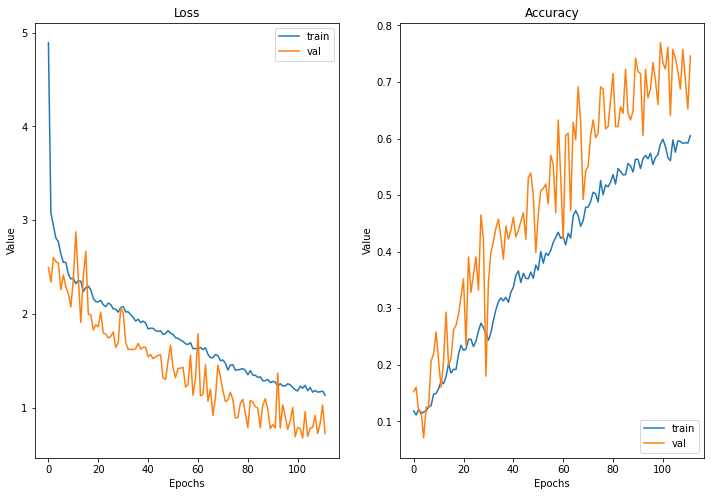

*******************number_5_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 5.0918 - accuracy: 0.1127
Epoch 00001: val_loss improved from inf to 3.24399, saving model to model1_best_0.h5
56/56 [==============================] - 3s 61ms/step - loss: 5.0918 - accuracy: 0.1127 - val_loss: 3.2440 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.0139 - accuracy: 0.1119
Epoch 00002: val_loss improved from 3.24399 to 3.10110, saving model to model1_best_0.h5
56/56 [==============================] - 3s 59ms/step - loss: 3.0211 - accuracy: 0.1116 - val_loss: 3.1011 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.9323 - accuracy: 0.1102
Epoch 00003: val_loss improved from 3.10110 to 2.90388, saving model to model1_best_0.h5
56/56 [==============================] - 3s 56ms/step - loss: 2.9283 - accuracy: 0.1105 - val_loss: 2.9039 

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.0775 - accuracy: 0.2438
Epoch 00028: val_loss improved from 1.83725 to 1.75216, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 2.0789 - accuracy: 0.2450 - val_loss: 1.7522 - val_accuracy: 0.3945 - lr: 8.0000e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 2.0624 - accuracy: 0.2460
Epoch 00029: val_loss did not improve from 1.75216
56/56 [==============================] - 3s 50ms/step - loss: 2.0605 - accuracy: 0.2467 - val_loss: 1.8836 - val_accuracy: 0.3477 - lr: 8.0000e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 2.0467 - accuracy: 0.2628
Epoch 00030: val_loss did not improve from 1.75216
56/56 [==============================] - 3s 49ms/step - loss: 2.0467 - accuracy: 0.2628 - val_loss: 1.8797 - val_accuracy: 0.3438 - lr: 8.0000e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 2.0385 - a

Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.5336 - accuracy: 0.4559
Epoch 00082: val_loss did not improve from 1.09294
56/56 [==============================] - 3s 48ms/step - loss: 1.5336 - accuracy: 0.4559 - val_loss: 1.2119 - val_accuracy: 0.5781 - lr: 2.6214e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.5142 - accuracy: 0.4715
Epoch 00083: val_loss did not improve from 1.09294
56/56 [==============================] - 3s 49ms/step - loss: 1.5142 - accuracy: 0.4715 - val_loss: 1.1209 - val_accuracy: 0.6211 - lr: 2.0972e-04
Epoch 84/500
56/56 [==============================] - ETA: 0s - loss: 1.4988 - accuracy: 0.4542
Epoch 00084: val_loss did not improve from 1.09294
56/56 [==============================] - 3s 49ms/step - loss: 1.4988 - accuracy: 0.4542 - val_loss: 1.1298 - val_accuracy: 0.6016 - lr: 2.0972e-04
Epoch 85/500
55/56 [============================>.] - ETA: 0s - loss: 1.5174 - accuracy: 0.4682
Epoch 00085: val_loss 

Epoch 135/500
56/56 [==============================] - ETA: 0s - loss: 1.1651 - accuracy: 0.5871
Epoch 00135: val_loss did not improve from 0.68838
56/56 [==============================] - 3s 52ms/step - loss: 1.1651 - accuracy: 0.5871 - val_loss: 0.8081 - val_accuracy: 0.7383 - lr: 1.6777e-04
Epoch 136/500
56/56 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.5999
Epoch 00136: val_loss did not improve from 0.68838
56/56 [==============================] - 3s 52ms/step - loss: 1.1547 - accuracy: 0.5999 - val_loss: 0.8263 - val_accuracy: 0.7344 - lr: 1.3422e-04
Epoch 137/500
55/56 [============================>.] - ETA: 0s - loss: 1.1574 - accuracy: 0.6045
Epoch 00137: val_loss improved from 0.68838 to 0.68722, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 1.1579 - accuracy: 0.6044 - val_loss: 0.6872 - val_accuracy: 0.7695 - lr: 1.3422e-04
Epoch 138/500
56/56 [==============================] - ETA: 0s - loss: 1.1030

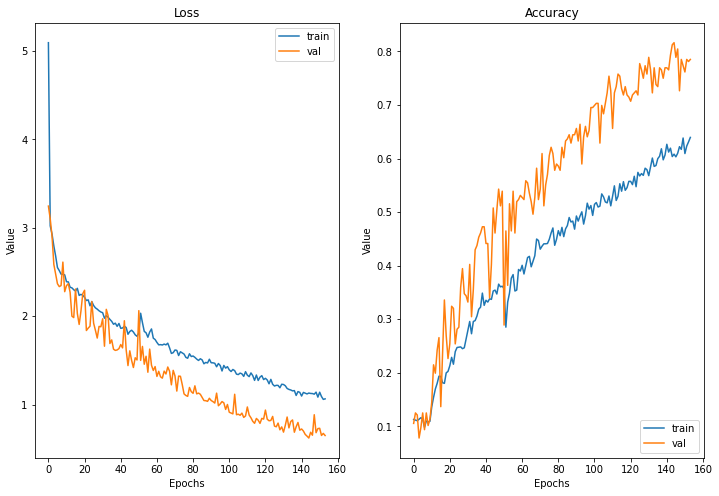

*******************number_6_kfold_model*******************
Epoch 1/500
55/56 [============================>.] - ETA: 0s - loss: 5.6685 - accuracy: 0.0943
Epoch 00001: val_loss improved from inf to 2.79521, saving model to model1_best_0.h5
56/56 [==============================] - 3s 60ms/step - loss: 5.6166 - accuracy: 0.0954 - val_loss: 2.7952 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 2.9743 - accuracy: 0.1148
Epoch 00002: val_loss did not improve from 2.79521
56/56 [==============================] - 3s 49ms/step - loss: 2.9712 - accuracy: 0.1150 - val_loss: 2.9689 - val_accuracy: 0.0977 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.8399 - accuracy: 0.1133
Epoch 00003: val_loss improved from 2.79521 to 2.41669, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 2.8399 - accuracy: 0.1133 - val_loss: 2.4167 - val_accuracy: 0.1680 - lr: 0.0010
Ep

Epoch 28/500
56/56 [==============================] - ETA: 0s - loss: 1.9816 - accuracy: 0.3058
Epoch 00028: val_loss did not improve from 1.62572
56/56 [==============================] - 3s 50ms/step - loss: 1.9816 - accuracy: 0.3058 - val_loss: 2.0946 - val_accuracy: 0.3555 - lr: 5.1200e-04
Epoch 29/500
55/56 [============================>.] - ETA: 0s - loss: 1.9952 - accuracy: 0.2937
Epoch 00029: val_loss did not improve from 1.62572
56/56 [==============================] - 3s 49ms/step - loss: 2.0001 - accuracy: 0.2913 - val_loss: 1.6378 - val_accuracy: 0.4102 - lr: 5.1200e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.9985 - accuracy: 0.2980
Epoch 00030: val_loss improved from 1.62572 to 1.47153, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 1.9985 - accuracy: 0.2980 - val_loss: 1.4715 - val_accuracy: 0.5078 - lr: 4.0960e-04
Epoch 31/500
55/56 [============================>.] - ETA: 0s - loss: 1.8973 - a

Epoch 55/500
56/56 [==============================] - ETA: 0s - loss: 1.6839 - accuracy: 0.4213
Epoch 00055: val_loss did not improve from 1.24229
56/56 [==============================] - 3s 49ms/step - loss: 1.6839 - accuracy: 0.4213 - val_loss: 1.3296 - val_accuracy: 0.5625 - lr: 2.6214e-04
Epoch 56/500
55/56 [============================>.] - ETA: 0s - loss: 1.6817 - accuracy: 0.4159
Epoch 00056: val_loss did not improve from 1.24229
56/56 [==============================] - 3s 50ms/step - loss: 1.6795 - accuracy: 0.4169 - val_loss: 1.2980 - val_accuracy: 0.5586 - lr: 2.6214e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.6715 - accuracy: 0.4193
Epoch 00057: val_loss improved from 1.24229 to 1.18182, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 1.6661 - accuracy: 0.4219 - val_loss: 1.1818 - val_accuracy: 0.5742 - lr: 2.6214e-04
Epoch 58/500
56/56 [==============================] - ETA: 0s - loss: 1.6750 - a

Epoch 82/500
55/56 [============================>.] - ETA: 0s - loss: 1.4193 - accuracy: 0.5097
Epoch 00082: val_loss did not improve from 0.90588
56/56 [==============================] - 3s 50ms/step - loss: 1.4267 - accuracy: 0.5067 - val_loss: 1.1285 - val_accuracy: 0.5820 - lr: 1.6777e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.4110 - accuracy: 0.5145
Epoch 00083: val_loss did not improve from 0.90588
56/56 [==============================] - 3s 49ms/step - loss: 1.4110 - accuracy: 0.5145 - val_loss: 1.1469 - val_accuracy: 0.5703 - lr: 1.6777e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 1.4059 - accuracy: 0.5131
Epoch 00084: val_loss did not improve from 0.90588
56/56 [==============================] - 3s 50ms/step - loss: 1.4111 - accuracy: 0.5112 - val_loss: 1.1013 - val_accuracy: 0.6055 - lr: 1.6777e-04
Epoch 85/500
55/56 [============================>.] - ETA: 0s - loss: 1.3839 - accuracy: 0.5205
Epoch 00085: val_loss 

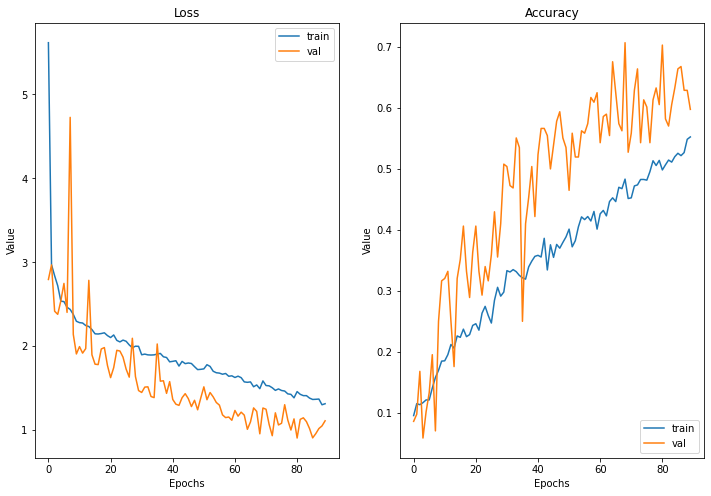

*******************number_7_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 5.4055 - accuracy: 0.1217
Epoch 00001: val_loss improved from inf to 4.87767, saving model to model1_best_0.h5
56/56 [==============================] - 3s 62ms/step - loss: 5.4055 - accuracy: 0.1217 - val_loss: 4.8777 - val_accuracy: 0.0742 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 2.9345 - accuracy: 0.1110
Epoch 00002: val_loss did not improve from 4.87767
56/56 [==============================] - 3s 49ms/step - loss: 2.9345 - accuracy: 0.1110 - val_loss: 11.7365 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 2.8890 - accuracy: 0.1077
Epoch 00003: val_loss improved from 4.87767 to 2.43018, saving model to model1_best_0.h5
56/56 [==============================] - 3s 59ms/step - loss: 2.8890 - accuracy: 0.1077 - val_loss: 2.4302 - val_accuracy: 0.1016 - lr: 0.0010
E

Epoch 28/500
55/56 [============================>.] - ETA: 0s - loss: 2.0073 - accuracy: 0.2750
Epoch 00028: val_loss improved from 1.73359 to 1.57492, saving model to model1_best_0.h5
56/56 [==============================] - 3s 58ms/step - loss: 2.0060 - accuracy: 0.2746 - val_loss: 1.5749 - val_accuracy: 0.5078 - lr: 5.1200e-04
Epoch 29/500
56/56 [==============================] - ETA: 0s - loss: 1.9964 - accuracy: 0.2969
Epoch 00029: val_loss did not improve from 1.57492
56/56 [==============================] - 3s 49ms/step - loss: 1.9964 - accuracy: 0.2969 - val_loss: 1.8451 - val_accuracy: 0.3594 - lr: 5.1200e-04
Epoch 30/500
56/56 [==============================] - ETA: 0s - loss: 1.9441 - accuracy: 0.3147
Epoch 00030: val_loss improved from 1.57492 to 1.51358, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 1.9441 - accuracy: 0.3147 - val_loss: 1.5136 - val_accuracy: 0.4609 - lr: 5.1200e-04
Epoch 31/500
56/56 [======================

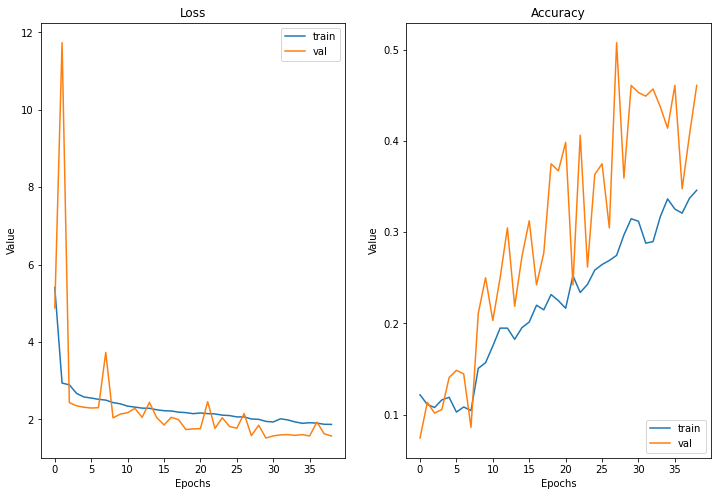

*******************number_8_kfold_model*******************
Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 5.1620 - accuracy: 0.1060
Epoch 00001: val_loss improved from inf to 6.75835, saving model to model1_best_0.h5
56/56 [==============================] - 3s 60ms/step - loss: 5.1620 - accuracy: 0.1060 - val_loss: 6.7583 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 2/500
55/56 [============================>.] - ETA: 0s - loss: 3.0163 - accuracy: 0.1153
Epoch 00002: val_loss improved from 6.75835 to 2.30314, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 3.0237 - accuracy: 0.1138 - val_loss: 2.3031 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/500
55/56 [============================>.] - ETA: 0s - loss: 2.8331 - accuracy: 0.1028
Epoch 00003: val_loss did not improve from 2.30314
56/56 [==============================] - 3s 51ms/step - loss: 2.8323 - accuracy: 0.1027 - val_loss: 3.4207 - val_accuracy: 0.1055 - lr: 0.0010
Ep

55/56 [============================>.] - ETA: 0s - loss: 1.6897 - accuracy: 0.4091
Epoch 00054: val_loss did not improve from 1.25100
56/56 [==============================] - 3s 49ms/step - loss: 1.6886 - accuracy: 0.4090 - val_loss: 1.3056 - val_accuracy: 0.5625 - lr: 2.6214e-04
Epoch 55/500
55/56 [============================>.] - ETA: 0s - loss: 1.7278 - accuracy: 0.3932
Epoch 00055: val_loss did not improve from 1.25100
56/56 [==============================] - 3s 50ms/step - loss: 1.7294 - accuracy: 0.3945 - val_loss: 1.3143 - val_accuracy: 0.5391 - lr: 2.6214e-04
Epoch 56/500
56/56 [==============================] - ETA: 0s - loss: 1.6565 - accuracy: 0.4208
Epoch 00056: val_loss did not improve from 1.25100
56/56 [==============================] - 3s 49ms/step - loss: 1.6565 - accuracy: 0.4208 - val_loss: 1.2547 - val_accuracy: 0.5742 - lr: 2.6214e-04
Epoch 57/500
55/56 [============================>.] - ETA: 0s - loss: 1.6396 - accuracy: 0.4318
Epoch 00057: val_loss improved from

Epoch 81/500
55/56 [============================>.] - ETA: 0s - loss: 1.5189 - accuracy: 0.4773
Epoch 00081: val_loss did not improve from 1.04379
56/56 [==============================] - 3s 50ms/step - loss: 1.5215 - accuracy: 0.4766 - val_loss: 1.0834 - val_accuracy: 0.6172 - lr: 1.3422e-04
Epoch 82/500
56/56 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.4860
Epoch 00082: val_loss improved from 1.04379 to 1.02964, saving model to model1_best_0.h5
56/56 [==============================] - 3s 57ms/step - loss: 1.4500 - accuracy: 0.4860 - val_loss: 1.0296 - val_accuracy: 0.6562 - lr: 1.0737e-04
Epoch 83/500
56/56 [==============================] - ETA: 0s - loss: 1.4143 - accuracy: 0.4961
Epoch 00083: val_loss did not improve from 1.02964
56/56 [==============================] - 3s 50ms/step - loss: 1.4143 - accuracy: 0.4961 - val_loss: 1.0552 - val_accuracy: 0.6602 - lr: 1.0737e-04
Epoch 84/500
55/56 [============================>.] - ETA: 0s - loss: 1.4383 - a

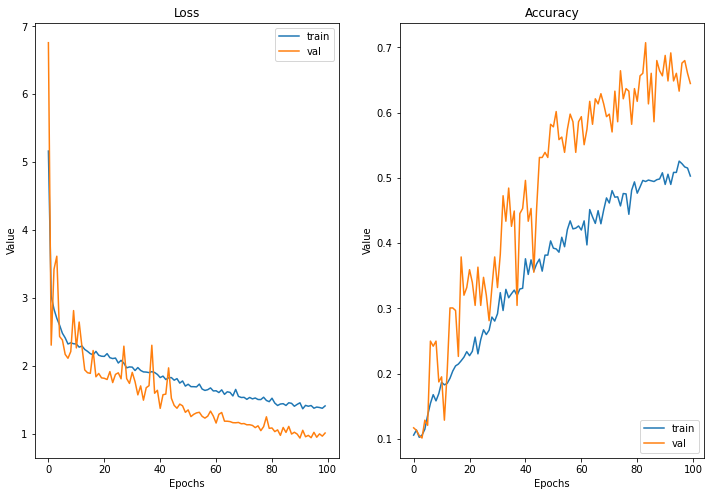

In [182]:
UC_train, UC_test = get_stacking(unet_classification, X_trains, y_trains)

In [42]:
RX_train = RX_train.reshape((RX_train.shape[0]))
RX_test = RX_test.reshape((RX_test.shape[0]))
# UC_train = UC_train.reshape((UC_train.shape[0], 1))
# UC_test = UC_test.reshape((UC_test.shape[0], 1)) 

In [45]:
RX_test

array([8, 2, 2, ..., 2, 2, 2])

In [205]:
new_X_train = np.concatenate((RX_train,  UC_train), axis = 1)
new_X_test = np.concatenate((RX_test,  UC_test), axis = 1)
print('origin :', X_trains.shape, TEST.shape)
print('new : ', new_X_train.shape, new_X_test.shape)

origin : (2048, 28, 28, 3) (20480, 28, 28, 3)
new :  (256, 2) (20480, 2)


In [206]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200)
lgbm.fit(new_X_train, y_train)
final_pred = lgbm.predict(new_X_test)

NameError: name 'y_train' is not defined

In [ ]:
final_pred

In [ ]:
submission['digit'] = final_pred

In [ ]:
submission

In [ ]:
submission.to_csv('./submission/rexnet_ensemble_channel3_submission.csv', index=False)